# Unbalanced Haar Treelet

This notebook explores an implementation of the Unbalanced Haar (UH) wavelet transform motivated by [Fryzlewicz (2018)](http://stats.lse.ac.uk/fryzlewicz/tguh/tguh.pdf). Given two sum variables $S_i = \frac{1}{\sqrt{n_i}}\sum_{l \in \mathcal{A}_i} x_l $ and $S_j = \frac{1}{\sqrt{n_j}}\sum_{l \in \mathcal{A}_j} x_l $ the UH transform obtains sum and difference variables by doing:

$\begin{pmatrix}
\text{sum}\\ 
\text{diff}
\end{pmatrix} = \begin{pmatrix}
a & b\\ 
-b & a
\end{pmatrix} \begin{pmatrix}
S_i\\ 
S_j
\end{pmatrix}$

Where $a = \sqrt{\frac{n_i}{n_i+n_j}}$ and $b = \sqrt{\frac{n_j}{n_i+n_j}}$. At every level in the algorithm sum variables generated by the UH transform are sums of merged variables in which each variable is given equal weight; the above definition of $S_i$ and $S_j$ is therefore justified. This is equivalent to rotating the basis vectors through an angle $\theta = \tan^{-1}(\sqrt{\frac{n_j}{n_i}})$.

It can be shown that the UH transform satisfies Theorem 1 and Lemma 1 in the original [treelet paper](https://arxiv.org/abs/0707.0481). When variables are negatively correlated UH merges lead to misleading results; intuitively, UH cannot rotate basis vectors clockwise. A solution is to transform basis vectors by $R(\theta)$: reflect basis vectors, apply standard UH rotation, re-reflect basis vectors. 

$R(\theta) = \begin{pmatrix}
1 & 0\\ 
0 & -1
\end{pmatrix} \begin{pmatrix}
\cos \theta & -\sin \theta\\ 
\sin \theta & \cos \theta
\end{pmatrix} \begin{pmatrix}
1 & 0\\ 
0 & -1
\end{pmatrix}$

This is equivalent to rotating basis vectors clockwise through an angle $\theta$. 

## Setup

In [2]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np 
import pandas as pd
import sys
import os

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import test_treelets_mixture_models as model
import utils
import UH_treelet as UH

## Test: negative correlations

In [5]:
X = model.linear_mixture_model(V = np.array([[-1,1,-1,0,0,0,0,0,0,0],
                                            [0,0,0,-1,1,-1,-1,0,0,0],
                                            [0,0,0,0,0,0,0,-1,1,0]])\
                                    .transpose(),
                         C = 2*np.identity(3), 
                         sigma = 1, 
                         n = 1000)

## Uncorrelated factors and non-overlapping loading vectors

With non-overlapping loadings UH identifies factor structure, however the procedure seems robust to noise; each loading vector is identified twice. 

In [6]:
tree = UH.treelet_decomposition(X = X,
                                L = 9)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]
loadings

array([[ 0.4472136 ,  0.        , -0.36514837],
       [ 0.4472136 ,  0.        , -0.36514837],
       [ 0.4472136 ,  0.        , -0.36514837],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.4472136 ,  0.        ,  0.54772256],
       [ 0.4472136 ,  0.        ,  0.54772256],
       [ 0.        ,  0.        ,  0.        ]])

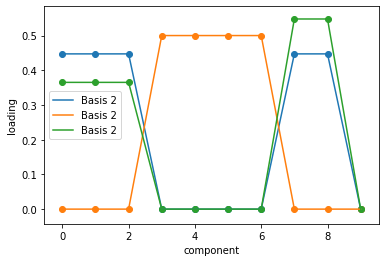

In [7]:
p,l = loadings.shape
loadings = np.abs(loadings)
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

## Correlated factors and non-overlapping loading vectors 

As with the previous example 

In [36]:
tree = UH.treelet_decomposition(X = X,L = 10)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]
loadings

array([[0.5       , 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [0.        , 0.47140452, 0.        ],
       [0.        , 0.47140452, 0.        ],
       [0.        , 0.47140452, 0.        ],
       [0.        , 0.57735027, 0.        ],
       [0.        , 0.        , 0.70710678],
       [0.        , 0.        , 0.70710678]])

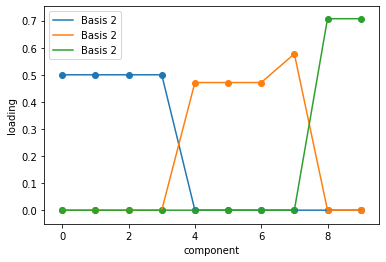

In [37]:
p,l = loadings.shape
loadings = np.abs(loadings)
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

## Uncorrelated factors and overlapping loading vectors $(p < n)$

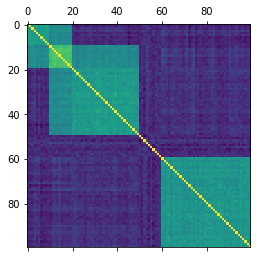

In [38]:
X = pd.read_csv("../data/3_overlapping_vectors_low_dim.csv").to_numpy()
plt.matshow(np.cov(X.transpose()))

In [39]:
tree = UH.treelet_decomposition(X = X,L = 100)
best_K_bases = pytree.best_basis(tree,3,X)
loadings = best_K_bases[0]["basis"]

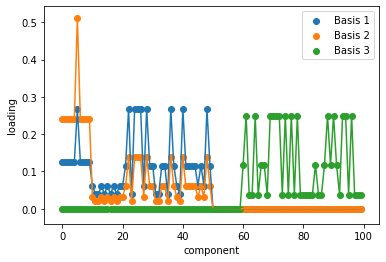

In [41]:
p,l = loadings.shape
loadings = np.abs(loadings)
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l], label = "Basis " + str(l+1))
    plt.plot(np.arange(p),loadings[:,l])

plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X).to_csv("../data/3_uncorrelated_factors.csv",index = False)

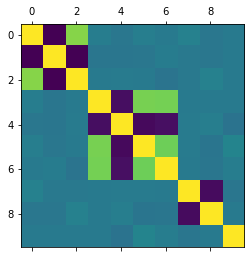

In [6]:
plt.matshow(np.cov(X.transpose()))

In [13]:
tree = pytree.treelet_decomposition(X = X,
                             L = 9, 
                             abs_ = False)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]
loadings

array([[0.70710678, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.70710678, 0.        , 0.        , 0.        ],
       [0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

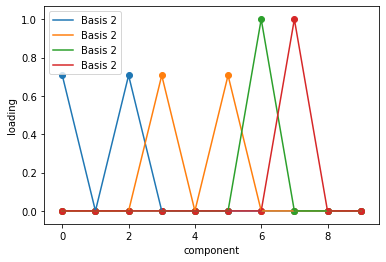

In [14]:
p,l = loadings.shape
loadings = np.abs(loadings)
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

In [9]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pca.components_.T 
loadings

array([[ 2.76740296e-02,  5.77216712e-01,  3.68279348e-02],
       [-1.01804754e-02, -5.76056476e-01,  8.81029083e-03],
       [ 3.08005675e-03,  5.77271202e-01, -3.13624229e-02],
       [ 5.02422372e-01,  1.68766405e-03, -2.36597367e-02],
       [-4.96652979e-01,  1.87822749e-02,  1.25727067e-02],
       [ 5.03485119e-01,  1.87120029e-04, -3.36225187e-03],
       [ 4.94267241e-01, -3.00218356e-02, -1.06562307e-02],
       [ 9.92450869e-03,  1.60053129e-02,  7.06087369e-01],
       [-2.62285913e-02,  1.42488672e-02, -7.05062301e-01],
       [ 3.80104085e-02, -4.64704592e-03, -3.26732804e-02]])

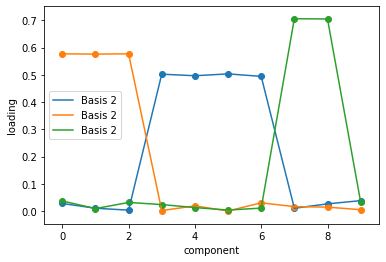

In [10]:
p,l = loadings.shape
loadings = np.abs(loadings)
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

In [11]:
tree = UH.treelet_decomposition(X = X,
                             L = 9)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]
loadings

array([[ 0.5       ,  0.        ,  0.        ],
       [-0.70710678,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.        ,  0.35355339,  0.        ],
       [ 0.        , -0.5       ,  0.        ],
       [ 0.        ,  0.35355339,  0.        ],
       [ 0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.        , -0.70710678],
       [ 0.        ,  0.        ,  0.        ]])